In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
import sys

In [2]:
# 파일 경로
File1 = "csv/exercise1_distribution.csv"
File2 = "csv/exercise2_shuffle.csv"

# load 함수
def load_csv(path: str) -> pd.DataFrame:
    # Load CSV and Parse timestamp
    df = pd.read_csv(path)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values(by="timestamp").reset_index(drop = True)  
    return df

In [3]:
# 폰트 설정
FONT_DIR = Path(r"C:\Users\User\Desktop\MyRepo\POSCO_KDT\2_wdh\7_EDA\fonts")
FONT_PATH = FONT_DIR / "Pretendard-Medium.otf"

if not FONT_PATH.exists():
    raise FileNotFoundError(f"폰트 파일 없음: {FONT_PATH}")

fm.fontManager.addfont(str(FONT_PATH))
font_name = fm.FontProperties(fname=str(FONT_PATH)).get_name()

rcParams["font.family"] = font_name
rcParams["axes.unicode_minus"] = False

## 1번 - 전체 VS 시간대별

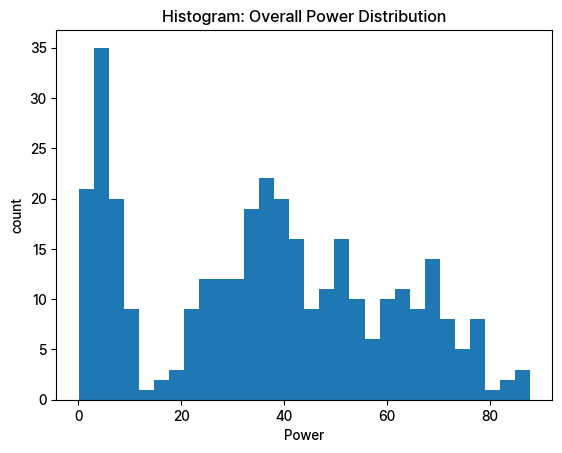

In [4]:
df = load_csv(File1)

# 시간대 컬럼 만들기
df["hour"] = df["timestamp"].dt.hour
df["is_night"] = df["hour"] < 6 # 0 ~ 5시는 야간

# 히스토그램 그리기
plt.figure()
plt.hist(df["power"], bins = 30)
plt.title("Histogram: Overall Power Distribution")
plt.xlabel("Power")
plt.ylabel("count")
plt.show()

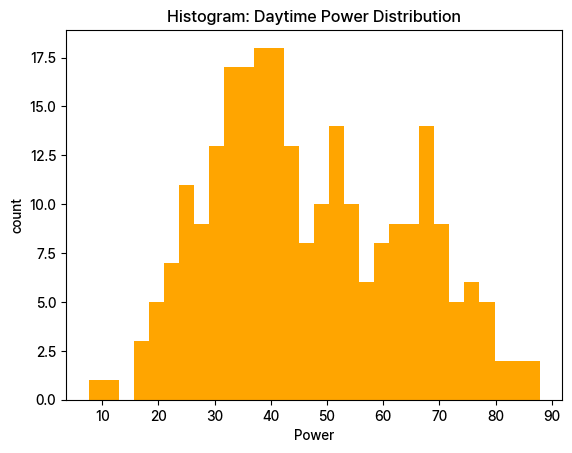

In [5]:
# 주간 히스토그램
day_df = df[df["is_night"] == False]
plt.figure()
plt.hist(day_df["power"], bins = 30, color = 'orange')
plt.title("Histogram: Daytime Power Distribution")
plt.xlabel("Power")
plt.ylabel("count")
plt.show()

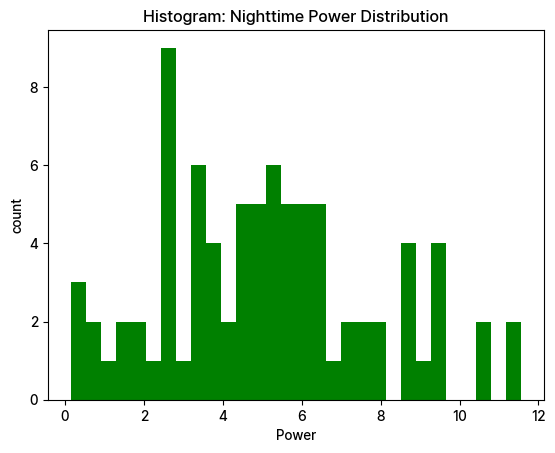

In [6]:
# 야간 히스토그램
night_df = df[df["is_night"] == True]
plt.figure()
plt.hist(night_df["power"], bins = 30, color = 'green')
plt.title("Histogram: Nighttime Power Distribution")
plt.xlabel("Power")
plt.ylabel("count")
plt.show()

## 2번 - 시간 섞기 VS 시간 유지

In [7]:
# 파일 불러오기
df2 = load_csv(File2)

# 기본 파생변수
df2["hour"] = df2["timestamp"].dt.hour
df2["day"] = df2["timestamp"].dt.date
print(df2.head())
print(df2.shape)

            timestamp     power  hour         day
0 2024-01-01 00:00:00  2.523508     0  2024-01-01
1 2024-01-01 01:00:00  4.035842     1  2024-01-01
2 2024-01-01 02:00:00  6.238794     2  2024-01-01
3 2024-01-01 03:00:00  3.308826     3  2024-01-01
4 2024-01-01 04:00:00  2.533339     4  2024-01-01
(336, 4)


In [8]:
# 시간대 평균 예측기
# 훈련 데이터에서 hour 별 평균 발전량을 만듦
# 테스트 데이터는 해당 hour 평균값으로 예측

# MAE (평균 절대 오차)
# 실제 값과 예측 값의 차이를 평균내어 예측 오차의 크기를 계산
def mae(y_true, y_pred) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return float(np.mean(np.abs(y_true - y_pred)))

def fit_hour_mean(train_df: pd.DataFrame) -> dict:
    # hour 별 평균 power
    hour_mean = train_df.groupby("hour")["power"].mean().to_dict()
    return hour_mean

def predict_hour_mean(test_df: pd.DataFrame, hour_mean: dict) -> np.ndarray:
    # hour 별 평균이 없는 경우 전체 평균으로 대체
    global_mean = np.mean(list(hour_mean.values()))
    return test_df["hour"].map(lambda h: hour_mean.get(h, global_mean)).to_numpy()

## 비교1 - 시간 순서 유지 분할 (정상적인 평가)

### 시간 기반 분할
- 앞: 80% 훈련, 뒤: 20% 테스트

In [10]:
def time_split(df2: pd.DataFrame, train_ratio = 0.8):
    split = int(len(df2) * train_ratio)
    train = df2.iloc[:split].copy()
    test = df2.iloc[split:].copy()
    return train, test

train_t, test_t = time_split(df2, 0.8)

hour_mean_t = fit_hour_mean(train_t)
pred_t = predict_hour_mean(test_t, hour_mean_t)
mae_t = mae(test_t["power"], pred_t)

print("MAE (time_based split): ", round(mae_t, 3))

MAE (time_based split):  6.088


### 비교2 - 랜덤 셔플 분할
랜덤 셔플 분할
- 데이터를 섞은 뒤 80 / 20 분할
- 시계열 데이터에서는 미래 정보가 섞일 위험이 있음
- 성능이 좋아 보이는 착시가 발생할 수 있다.


In [20]:
def random_split(df2: pd.DataFrame, train_ratio = 0.8, seed = 42):
    shuffled = df2.sample(frac = 1, random_state = seed).reset_index(drop = True)
    split = int(len(shuffled) * train_ratio)
    train = shuffled.iloc[:split].copy()
    test = shuffled.iloc[split:].copy()
    return train, test

train_s, test_s = random_split(df2, 0.8, seed = 42)

hour_mean_s = fit_hour_mean(train_s)
pred_s = predict_hour_mean(test_s, hour_mean_s)
mae_s = mae(test_s["power"], pred_s)

print("MAE (random shuffle split): ", round(mae_s, 3))

MAE (random shuffle split):  6.607
